In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

C:\Users\dgdl1\AppData\Local\Temp\ipykernel_5444\12173566.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm_month = dust.resample('M').mean()


CV MSE: 26.371

Test MSE=12.506, RMSE=3.536, R2=0.397


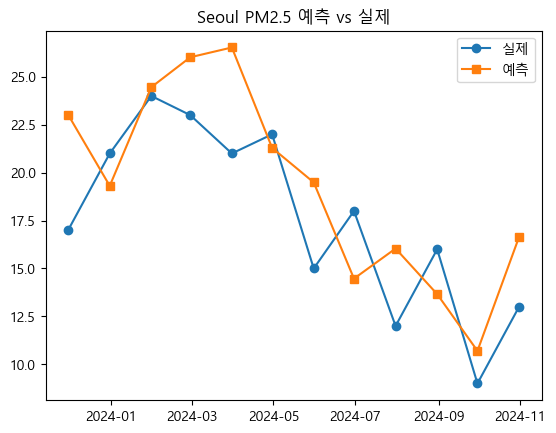

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# 랜덤포레스트 모델을 이용한 초미세먼지 예측

# 1. 데이터 불러오기 & 월별 집계
dust = pd.read_excel('pm25_top30_fixed.xlsx', index_col=0, parse_dates=True)
dust = dust.apply(pd.to_numeric, errors='coerce').dropna(how='any')
pm_month = dust.resample('M').mean()

# 2. lag 피처 추가 (지난 1~3개월) / 지연율 고려해서 10,11,12로도 해봤는데 1,2,3이 오히려 더 높게 나옴옴
for lag in [1,2,3]:
    pm_month[f'pm_lag{lag}'] = pm_month['Seoul'].shift(lag)  # 예시: 서울 기준
pm_month = pm_month.dropna()

# 3. 계절 더미
pm_month['month'] = pm_month.index.month
month_dummies = pd.get_dummies(pm_month['month'], prefix='m')
pm_month = pd.concat([pm_month, month_dummies], axis=1)

# 4. 피처/타깃 분리
FEATURES = [col for col in pm_month.columns if 'lag' in col or col.startswith('m_')]
X = pm_month[FEATURES]
y = pm_month[['Seoul']]  # 예측 대상 도시 선택, 다른 도시도 예측하려면 도시명 넣으시면 됩니다.

# 5. 시계열 교차검증 & RandomForest 학습
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y.values.ravel(),
                         cv=tscv,
                         scoring='neg_mean_squared_error')
print("CV MSE:", -scores.mean().round(3))

# 6. 마지막 구간을 테스트 세트로 분리
train_X = X.iloc[:-12];  test_X = X.iloc[-12:]
train_y = y.iloc[:-12];  test_y = y.iloc[-12:]

model.fit(train_X, train_y.values.ravel())
pred = model.predict(test_X)

# 7. 성능 평가
mse   = mean_squared_error(test_y, pred)
rmse  = np.sqrt(mse)
r2    = r2_score(test_y, pred)
print(f"\nTest MSE={mse:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

# 8. 시각화
import matplotlib.pyplot as plt
plt.plot(test_y.index, test_y, marker='o', label='실제')
plt.plot(test_y.index, pred,    marker='s', label='예측')
plt.title('Seoul PM2.5 예측 vs 실제')
plt.legend(); plt.show()


C:\Users\dgdl1\AppData\Local\Temp\ipykernel_5444\2733263236.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm_month = dust.resample('M').mean()


Fitting 5 folds for each of 30 candidates, totalling 150 fits


f:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "f:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "f:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "f:\ProgramData\anaconda3\Lib\site-packages

최적 파라미터: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
CV MSE (best): 32.411

=== Test 성능 ===
MSE: 23.952, RMSE: 4.894, R2: -0.155


C:\Users\dgdl1\AppData\Local\Temp\ipykernel_5444\2733263236.py:72: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
f:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


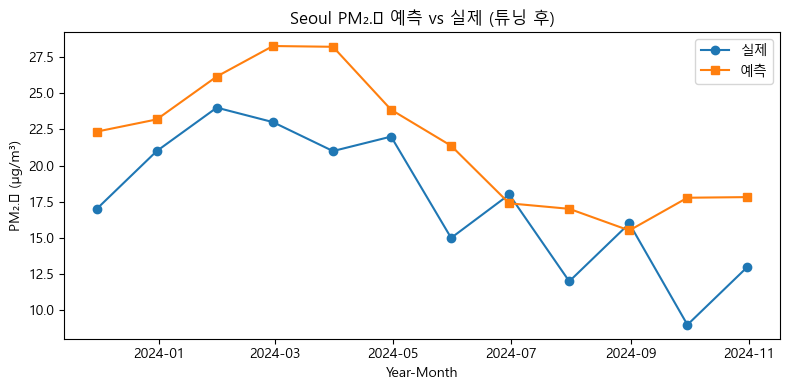

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#이번에는 RandomizedSearchCV를 이용한 하이퍼파라미터 튜닝과 더 많은 lag 피처(1~6개월)를 사용함함

# 1. 데이터 불러오기 & 월별 집계
dust = pd.read_excel('pm25_top30_fixed.xlsx', index_col=0, parse_dates=True)
dust = dust.apply(pd.to_numeric, errors='coerce').dropna(how='any')
pm_month = dust.resample('M').mean()

# 2. lag 피처 추가 (1~6개월)
for lag in range(1,7):
    pm_month[f'lag_{lag}'] = pm_month['Seoul'].shift(lag)
pm_month.dropna(inplace=True)

# 3. 계절 더미 (옵션)
pm_month['month'] = pm_month.index.month
pm_month = pd.get_dummies(pm_month, columns=['month'], prefix='m')

# 4. 데이터 분리
FEATURES = [c for c in pm_month.columns if c.startswith('lag_') or c.startswith('m_')]
X = pm_month[FEATURES]
y = pm_month['Seoul']

train_X, test_X = X.iloc[:-12], X.iloc[-12:]
train_y, test_y = y.iloc[:-12], y.iloc[-12:]

# 5. 하이퍼파라미터 그리드
param_dist = {
    'n_estimators': [50,100,200,300],
    'max_depth': [None,5,10,20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['auto','sqrt','log2']
}

# 6. RandomizedSearchCV 설정
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=30, cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=1
)
search.fit(train_X, train_y)

print("최적 파라미터:", search.best_params_)
print("CV MSE (best):", -search.best_score_.round(3))

# 7. 최적 모델로 테스트 예측
best_rf = search.best_estimator_
pred = best_rf.predict(test_X)

mse = mean_squared_error(test_y, pred)
rmse = np.sqrt(mse)
r2  = r2_score(test_y, pred)
print(f"\n=== Test 성능 ===\nMSE: {mse:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

# 8. 시각화
plt.figure(figsize=(8,4))
plt.plot(test_y.index, test_y, marker='o', label='실제')
plt.plot(test_y.index, pred, marker='s', label='예측')
plt.title('Seoul PM₂.₅ 예측 vs 실제 (튜닝 후)')
plt.xlabel('Year-Month')
plt.ylabel('PM₂.₅ (μg/m³)')
plt.legend()
plt.tight_layout()
plt.show()
